# Figure 2 | Transcriptomic diversity across the thalamus.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_images as cimg
from abc_merfish_analysis import ccf_plots as cplots
from abc_merfish_analysis import ccf_erode as cerd
from abc_merfish_analysis import diversity_metrics as divmet
from abc_merfish_analysis import diversity_plots as dplot
import abc_merfish_analysis.distance_metrics as dm

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

## Load thalamus data

In [2]:
obs_th = abc.load_standard_thalamus(data_structure='obs')

### load CCF structure images

In [3]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images = cerd.merge_substructures(ccf_images, ccf_level='structure')

# we only need to load the boundaries for sections that contain the thalamus
z_col = 'z_reconstructed'
sections_all = sorted(obs_th[z_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

### Exclude cells that fall withint 50um of a CCF boundary

In [4]:
# We'll use the eroded CCF structures to calculate similarity metrics
ccf_metrics_level = "structure"
obs_erode, ccf_label_eroded = cerd.label_cells_by_eroded_ccf(obs_th, ccf_images, ccf_level=ccf_metrics_level, distance_px=5) # default is erosion by 5px (50um)
ccf_label = ccf_label_eroded
# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs_erode.loc[lambda df: df['z_section']==6.6, ccf_label_eroded] = 'unassigned'

### Load color palettes

In [5]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() 

ccf_palette = abc.get_ccf_palette('substructure')

In [6]:
# if you reload abc_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [7]:
results_dir = '../../results'

## Fig. 2A-C | Similarity heatmaps: Thalamic nuclei vs cell types

In [8]:
# Set shared figure parameters

# pre-selected, 25 nuclei to show
regions_to_plot = abc.TH_DIVERSITY_STRUCTURES

# set color map
cmap = dm.CMAP_PURPLES_256
# dm.plot_cmap_lightness(cmap) # uncomment to see cmap is perceptually uniform

# set colorbar range
vmin = 0
vmax = 0.8

In [9]:
# Set per-level figure parameters
fig_index = 2
fig_letters = ['A', 'B',]
taxonomy_levels = ['subclass', 'supertype']
fig_size_hm = [
    [1.8, 3],
    [5.8,3],
]
fig_size_xaxis = [
    [1.8, 3],
    [5.7,3],
]

### Fig. 2A-B | Similarity heatmap: Thalamic nuclei vs subclasses, supertypes

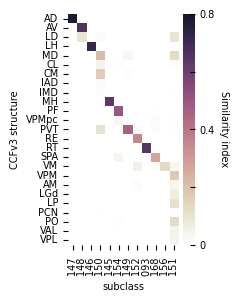

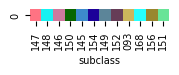

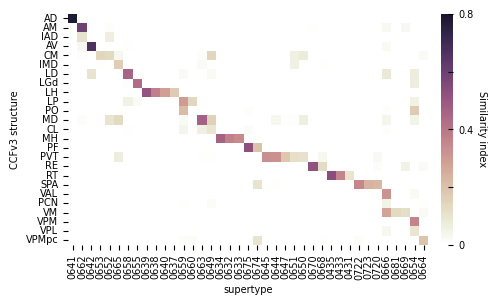

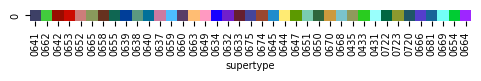

In [10]:
# Generate a similarity heatmap for each taxonomy level
for i, taxonomy_level in enumerate(taxonomy_levels):
    
    # Calculate cell-wise similarity between CCFv3 structures and cell types at
    # the current taxonomy level
    dist, y_names, x_names = dm.cluster_distances_from_labels(
        obs_erode, 
        y_col=ccf_label, 
        x_col=taxonomy_level, 
        y_names=sorted(regions_to_plot),
        x_names=sorted(obs_erode[taxonomy_level].unique())
    )
    # reorder the y-axis based on the similarity of the x-axis
    # (gives a more diagonal appearance to the heatmap)
    y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)
    
    # truncate x_names to just the cell type ID, rather than the full name
    x_names_ids_only = [name[0:4] for name in x_names]

    # Plot the similarity heatmap
    fig_hm = dm.plot_ordered_similarity_heatmap(
        dist, 
        y_order=y_order, 
        x_order=x_order, 
        y_names=y_names, 
        x_names=x_names_ids_only,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
    )
    # format plot
    fig_hm.set_size_inches(fig_size_hm[i])
    fig_hm.gca().set_xlabel(taxonomy_level)
    fig_hm.gca().set_ylabel('CCFv3 structure')

    # save heatmap
    fig_hm.savefig(
        f'{results_dir}/fig{fig_index}{fig_letters[i]}_similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-reorderedY.pdf', 
        transparent=True, bbox_inches='tight'
    )

    # Plot colored labels for the x-axis categories
    fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(
        x_names, 
        x_order, 
        abc_palettes[taxonomy_level]
    )
    # format and save 
    fig_xlabel_colors.gca().set_xlabel(taxonomy_level)
    fig_xlabel_colors.set_size_inches(fig_size_xaxis[i])
    fig_xlabel_colors.savefig(
        f'{results_dir}/fig{fig_index}{fig_letters[i]}_similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
        transparent=True, bbox_inches='tight'
    )

### Fig. 2C | Similarity heatmap: Thalamic nuclei vs clusters

In [11]:
# cluster-specific parameters
regions_to_plot_manual_clusters = [
    "AD", "AM", "AV", "CM", "IAD", "IMD", 
    "LD", "LGd", "LP", "PVT", "MD", "CL",
    "PCN", "VAL", "VM", "VPM", "VPMpc",
    "PO", "VPL", "RE", 
    "LH", "MH", "PF",  "RT", "SPA"
]

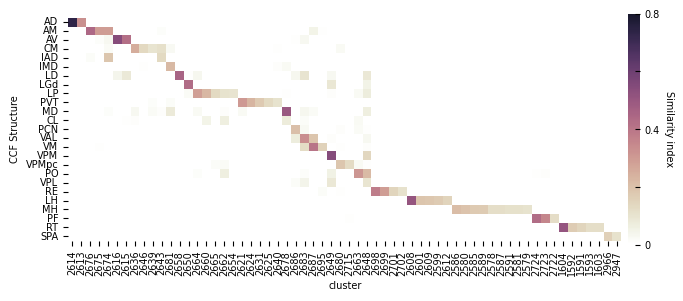

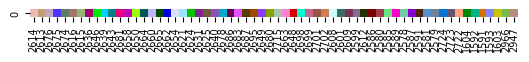

In [12]:
# thalamic nuclei vs cluster similarity
taxonomy_level = 'cluster'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_erode, y_col=ccf_label, x_col=taxonomy_level, 
                            y_names=regions_to_plot_manual_clusters, #sorted(regions_to_plot),
                            x_names=sorted(obs_erode[taxonomy_level].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

x_names_ids_only = [name[0:4] for name in x_names]

fig_hm_cluster = dm.plot_ordered_similarity_heatmap(
    dist, 
    y_order=y_order, x_order=x_order, 
    y_names=y_names, x_names=x_names_ids_only,
    cmap=cmap,
    vmin=vmin, vmax=vmax,
)

fig_hm_cluster.set_size_inches(8.5,3)
fig_hm_cluster.gca().set_xlabel(taxonomy_level)
fig_hm_cluster.gca().set_ylabel('CCF Structure')


fig_hm_cluster.savefig(f'{results_dir}/fig2C_similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-manualY.pdf', 
                        transparent=True, bbox_inches='tight')
fig_hm_cluster.savefig(f'{results_dir}/fig2C_similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-manualY.png', 
                        dpi=600, transparent=True, bbox_inches='tight')


# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                  x_order, 
                                                  abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(6.3,3)
fig_xlabel_colors.savefig(f'{results_dir}/fig2C_similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
                          transparent=True, bbox_inches='tight')

## Fig. 2D-E: Examples of cluster:nuclei correspondance

In [13]:
coords = '_reconstructed'
x_col = 'x'+coords
y_col = 'y'+coords
z_col = 'z'+coords


# set kwargs fpr annotated cluster plots
kwargs_cluster_annotations = dict(
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=2,
    figsize=(4, 2),
    face_palette=None,
    edge_color='silver'
    )

In [14]:
# subset to just the left hemisphere to save space to display multiple sections
obs_th_left = obs_th.loc[obs_th['left_hemisphere']]

# Need to reload ccf images for just the left hemisphere
ccf_images_left = abc.get_ccf_labels_image(subset_to_left_hemi=True)
# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images_left = cerd.merge_substructures(ccf_images_left, ccf_level='structure')

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th_left[z_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries_left = cimg.sectionwise_label_erosion(ccf_images_left, 
                                                     distance_px=1, 
                                                     fill_val=0, 
                                                     return_edges=True, 
                                                     section_list=sections_int
                                                     )

### Fig. 2D | VAL & VM

/code/abc_merfish_analysis/ccf_plots.py:1037: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


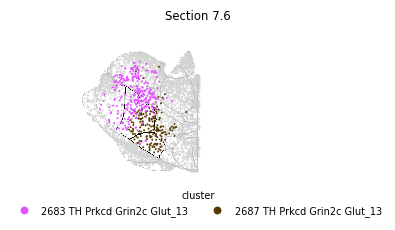

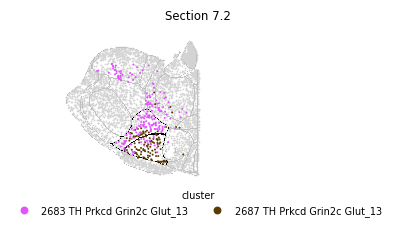

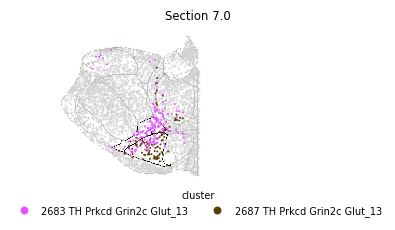

In [15]:
# get the cluster annotations for the nucleus of interest
nucleus = ['VAL', 'VM']
obs_annot = abc.get_obs_from_annotations(nucleus, obs_th_left, taxonomy_level='cluster')
# # subset to left hemisphere
# obs_annot = obs_annot.loc[obs_annot['left_hemisphere']]
# drop a couple that seem to be due to CCF misalignment
cat_to_drop = ['2686 TH Prkcd Grin2c Glut_13', '2684 TH Prkcd Grin2c Glut_13', '2695 RE-Xi Nox4 Glut_2']
obs_annot = obs_annot.loc[~obs_annot['cluster'].isin(cat_to_drop)]


# Let's look at the cell types in the ATN in one sample section
# sections_all_VAL_VM = [7.8, 7.6, 7.2, 7.0, 6.8, 6.6]
# ant. to post.: C57BL6J-638850.42, C57BL6J-638850.40, C57BL6J-638850.39, C57BL6J-638850.38, C57BL6J-638850.37
sections_to_plot = [7.6, 7.2, 7.0] # C57BL6J-638850.40, C57BL6J-638850.39, C57BL6J-638850.38
nuclei_highlight = nucleus
taxonomy_level = 'cluster'

figs_annot = cplots.plot_ccf_overlay(obs_annot,
                                     ccf_images_left,
                                     boundary_img=ccf_boundaries_left,
                                     bg_cells=obs_th_left, 
                                     ccf_highlight=nuclei_highlight,
                                     point_hue=taxonomy_level, 
                                     sections=sections_to_plot, # sections_all_VAL_VM
                                     point_palette=abc_palettes[taxonomy_level],
                                     legend='cells',
                                     **kwargs_cluster_annotations)

for i, sec in enumerate(sections_to_plot):
    sec_str = int(sec*10)
    figs_annot[i].savefig(f'{results_dir}/fig2D_cluster_annotations_z{sec_str}_VAL_VM.pdf',
                        transparent=True, bbox_inches='tight')
    figs_annot[i].savefig(f'{results_dir}/fig2D_cluster_annotations_z{sec_str}_VAL_VM.png',
                        transparent=True, bbox_inches='tight', dpi=1200)

### Fig. 2E | Anterior thalamic nuclei (ATN: AD, AV, AM)

/code/abc_merfish_analysis/ccf_plots.py:1037: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


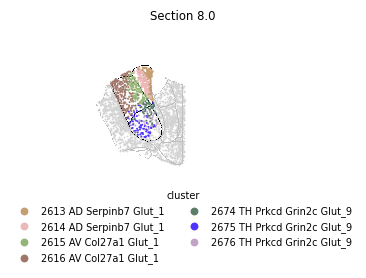

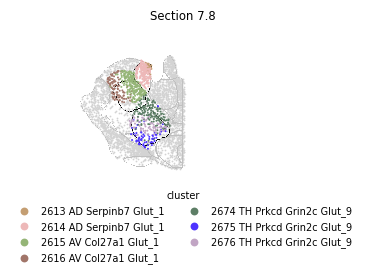

In [16]:
# get the cluster annotations for the nucleus of interest
nucleus = ['AD', 'AM', 'AV']
obs_annot_left = abc.get_obs_from_annotations(nucleus, obs_th_left, taxonomy_level='cluster')

# Let's look at the cell types in the ATN in one sample section
# anterior to posterior: C57BL6J-638850.44, C57BL6J-638850.43
sections_to_plot = [8.0, 7.8]
nuclei_highlight = ['AD', 'AMd', 'AMv', 'AV', 'AV']
taxonomy_level = 'cluster'

plt.rcParams.update({'font.size': 7})
figs_annot = cplots.plot_ccf_overlay(obs_annot_left, 
                                    ccf_images_left,
                                    boundary_img=ccf_boundaries_left,
                                    bg_cells=obs_th_left, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_to_plot,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cluster_annotations)

for i, sec in enumerate(sections_to_plot):
    sec_str = int(sec*10)
    figs_annot[i].savefig(f'{results_dir}/fig2E_cluster_annotations_z{sec_str}_ATN_left.pdf',
                        transparent=True, bbox_inches='tight')
    figs_annot[i].savefig(f'{results_dir}/fig2E_cluster_annotations_z{sec_str}_ATN_left.png',
                        transparent=True, bbox_inches='tight', dpi=1200)

## Fig. 2F-G | Cluster diversity metrics

In [17]:
# calculate per-nucleus diversity metrics
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)

# set color map
cmap = sns.color_palette("mako_r", as_cmap=True)

### Fig. 2F | Per nucleus cluster diversity
Aggregates per nucleus, across all sections

#### (Left) Inverse Simpson's Index (ISI)

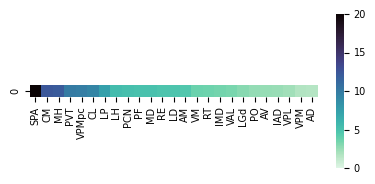

In [18]:
# plot the cell type counts in the CCF structures
# Rank thalamic nuclei by their diversity, as measured by the inverse simpson's index (ISI)
taxonomy_level = 'cluster'
metrics_to_sort_by = th_ccf_metrics.loc[abc.TH_DIVERSITY_STRUCTURES,:]
isi_sorted_metrics = metrics_to_sort_by.sort_values(
                                by=[f'inverse_simpsons_{taxonomy_level}'],
                                ascending=False
                                )
isi_sorted_regions = isi_sorted_metrics.index

# plot 
fig_isi_rank, ax = plt.subplots(figsize=(4.65,2))
# log transforming just to make the colormap more divergent
sns.heatmap(
    # np.log(
    [isi_sorted_metrics[f'inverse_simpsons_{taxonomy_level}'].values],#),
            square=True, 
            vmin=0,
            vmax=20,
            cmap=sns.color_palette("mako_r", as_cmap=True),
            xticklabels=isi_sorted_regions,
            ax=ax)

fig_isi_rank.savefig(f'{results_dir}/fig2F_diversity_rank_1Dheatmap_isi_cluster.pdf', 
                     transparent=True, bbox_inches='tight')

#### (Right) Cluster count & proportions

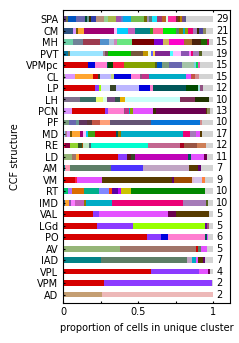

In [19]:
# cluster proportions
taxonomy_level = 'cluster'
fig_bp_cluster = dplot.barplot_stacked_proportions(
    obs_erode, 
    taxonomy_level, 
    th_ccf_metrics, 
    palette=abc.get_thalamus_cluster_palette(),
    ccf_regions=abc.TH_DIVERSITY_STRUCTURES,
    legend=False, 
    min_cell_frac=0.01,  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
    ordered_regions=isi_sorted_regions, #, cpc_sorted_regions
    orientation='horizontal',
)
fig_bp_cluster.set_size_inches(2.15,3.8)
fig_bp_cluster.gca().tick_params(length=0.02*72)

ax_cluster = fig_bp_cluster.gca()
xticklabels_cluster = [x.get_text() for x in ax_cluster.get_xticklabels()]

fig_bp_cluster.savefig(f'{results_dir}/fig2F_{taxonomy_level}_diversity_barplot_ordered-isi-cluster.pdf', 
                       transparent=True, bbox_inches='tight')

### Fig 2G | Local cluster diversity 
local = 15 nearest neighbors in same section

In [20]:
# calculate local diversity index using Inverse Simpson's Index (ISI) as metric
local_isi_df = divmet.calculate_local_diversity_metric(obs_erode, 
                                                       divmet.inverse_simpsons_index, 
                                                       metric_name='isi', 
                                                       n_neighbors=15)
obs_erode = obs_erode.join(local_isi_df)

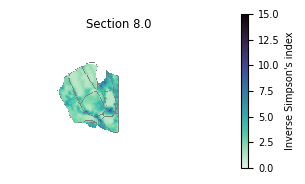

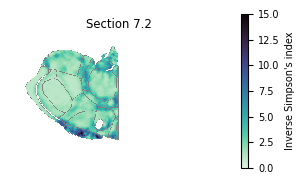

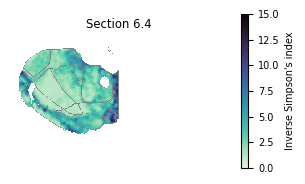

In [21]:
metric_name = 'local_isi_cluster'

# subset to left hemisphere for plotting
obs_erode_left = obs_erode.loc[obs_erode['left_hemisphere']]

for section in abc.TH_EXAMPLE_Z_SECTIONS:
    fig = cplots.plot_local_metric_ccf_section(obs_erode_left, ccf_images_left,
                                              section, metric_name, cmap=cmap, label="Inverse Simpson's index")

    fig.set_size_inches(3.5, 2)
    fig.savefig(f'{results_dir}/fig2G_ccf_local_isi_cluster_sec{int(section*10)}.png',
                transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(f'{results_dir}/fig2G_ccf_local_isi_cluster_colorbar.pdf',
                transparent=True, bbox_inches='tight')